# Plot matern correlation lengths

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
from xmitgcm import open_mdsdataset,utils
from xgcm import Grid
import ecco_v4_py

import pych.ecco as pe

from matern import MaternField
from llcutils import get_pacific

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = SLURMCluster()
cluster.adapt(minimum=0, maximum=10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.1.1.9:8787/status,
Dashboard: http://10.1.1.9:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.1.9:33738,Workers: 0
Dashboard: http://10.1.1.9:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
plt.style.use('./correlation.mplstyle')

In [6]:
xi = 1

In [53]:
def readme(n_range, drop_coords=True):
    ds = xr.open_zarr(f'/scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/zstores/matern.{n_range:02d}dx.{xi:02}xi.zarr',
                      chunks={'k':50, 'sample':100})
    #ds = ds.isel(sample=slice(100))
    if drop_coords:
        ds = ds.reset_coords(drop=True)
    ds = get_pacific(ds)
    return ds

In [54]:
def preprocess(xds, grid):
    
    with xr.set_options(keep_attrs=True):
        
        xds['variance'] = 1/xds['smooth3Dnorm001']**2
        xds['sigma'] = 1/xds['smooth3Dnorm001']
        xds['smooth3Dnorm001'] = xds['smooth3Dnorm001'].where(grid['maskC'])
        #xds['ginv_norm'] = xds['smooth3Dfld001'] * xds['smooth3Dnorm001']
        tmp = xds['smooth3Dfld001'].data * xds['smooth3Dnorm001'].data[None]
        xdalike = xds['smooth3Dfld001']
        xds['ginv_norm'] = xr.DataArray(tmp, coords=xdalike.coords, dims=xdalike.dims)
        
        xds['variance'].attrs = {'label':r'$\hat{\sigma}^2$'}
        xds['sigma'].attrs = {'label':r'$\hat{\sigma}$'}
        #xds['smooth3Dmean001'] = xds['smooth3Dfld001'].mean('sample')
    return xds

In [55]:
all_ranges = [5, 10, 15, 20]
dsd = {n_range: readme(n_range) for n_range in all_ranges}

# Get a single grid dataset and drop the others
grid = readme(5, drop_coords=False).coords.to_dataset()
grid = grid.persist()

In [56]:
for _, ds in dsd.items():
    ds = preprocess(ds, grid)

In [57]:
grid['maskC'] = grid['maskC'].persist()
for xds in dsd.values():
    for key in ['smooth3Dnorm001','smooth3Dmean001','ginv_norm']:
        xds[key] = xds[key].persist()

### Correlation lengths

In [58]:
def calc_correlation_field(xda, mask, sample_mean,
                           dimlist=('k',),
                           n_shift=15, 
                           selection=None):
    xds = xr.Dataset()
    
    # Do this part once
    x_deviation = (xda - sample_mean).persist()
    x_ssr_inv = (1/np.sqrt( (x_deviation.sel(selection)**2).sum('sample') )).persist()
    
    shifty = np.arange(-n_shift,n_shift+1)
    xds['shifty'] = xr.DataArray(shifty, coords={'shifty':shifty}, dims=('shifty',))
    for dim in dimlist:
        cname = f'corr_{dim}'
        
        avg_corr = []
        std_corr = []
        q_corr = []
        for s in shifty:
            avg, std = _xcalc_shifted(x_deviation, x_ssr_inv, int(s), dim, selection)
            avg_corr.append(avg)
            std_corr.append(std)
            #q_corr = _xcalc_shifted(x_deviation, x_ssr_inv, int(s), dim, selection)
        xds[cname+'_avg'] = xr.concat(avg_corr, dim='shifty')
        xds[cname+'_std'] = xr.concat(std_corr, dim='shifty')
        #xds[cname] = xr.concat()
        
    return xds.persist()

def _xcalc_shifted(xdev, xssrinv, n_shift, dim, selbox):
    
    y_deviation = xdev.shift({dim:n_shift}).sel(selbox)
    numerator = (xdev.sel(selbox)*y_deviation).sum('sample')
    y_ssr = np.sqrt( (y_deviation**2).sum('sample'))
    full_field = numerator / y_ssr * xssrinv
    
    sum_dims = tuple(x for x in xssrinv.dims if x != dim)
    #quantile = full_field.quantile([.2, .5, .8], dim=sum_dims, method='inverted_cdf').expand_dims({'shift':[n_shift]})
    #return quantile
    avg = full_field.mean(sum_dims).expand_dims({'shifty':[n_shift]})
    std = full_field.std(sum_dims).expand_dims({'shifty':[n_shift]})
    return avg, std

In [59]:
# Compute approximate correlation
outer = {'ix':slice(40,120), 'iy':slice(200,45)}
inner = {'ix':slice(60,100), 'iy':slice(160,80)}

cdsd = {}
for n_range, xds in dsd.items():
    cc = calc_correlation_field(xds['ginv_norm'].sel(outer),
                                           mask=grid['maskC'].sel(outer),
                                           sample_mean=xds['smooth3Dmean001'].sel(outer),
                                           dimlist=('ix','iy','k'),
                                           n_shift=2*xi*n_range,
                                           selection=inner)

    # Compute prediction
    mf = MaternField(grid['maskC'], n_range=n_range, horizontal_factor=xi)
    cc['delta_khat'] = np.abs(cc['shifty'])
    cc['ideal_corr_k'] = mf.ideal_correlation(distance=cc['delta_khat'])
    cdsd[n_range] = cc

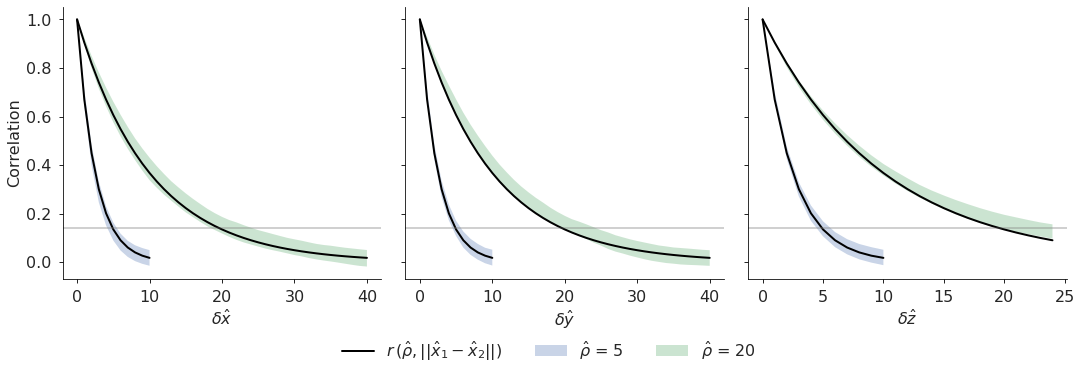

In [63]:
kk = 25
ix = 80
iy = 120

ncols = 3
nrows = 1

fig,axs = plt.subplots(nrows,ncols,figsize=(18,5*nrows),
                       sharey=True)

for n_range, xds in cdsd.items():
    
    for dim, dsel, ax in zip(['ix','iy','k'], [ix,iy,kk], axs):
        
        theory_label = r'$r\,(\hat{\rho},||\hat{x}_1-\hat{x}_2||)$' if n_range == 5 and dim == 'ix' else None
        exp_label=r'$\hat{\rho}$ = %d' % n_range if dim == 'ix' else None
        
        # for simplicity, just showing positive, but it's the same either way...
        condition = xds['shifty'] >= 0
        if dim == 'k':
            condition = condition & (x<25)
            
        x = xds[f'delta_khat'].where(condition)
        theory = xds[f'ideal_corr_k'].where(condition)
        yavg = xds[f"corr_{dim}_avg"].sel({dim:dsel}).where(condition)
        ystd = xds[f"corr_{dim}_std"].sel({dim:dsel}).where(condition)
        
        ax.plot(x, theory, label=theory_label, color='black')
        ax.fill_between(x,yavg-ystd, yavg+ystd,
                        alpha=.3,
                        label=exp_label)

        lbl = dim[-1]
        lbl = 'z' if lbl == 'k' else lbl
        ax.axhline(y=0.14, color='gray', alpha=.2)
        ax.set(xlabel=r'$\delta\hat{%s}$' % lbl,ylabel='',title='')
        
axs[0].set_ylabel('Correlation')

fig.subplots_adjust(wspace=.075)
fig.legend(ncol=5,
           loc='center',
           bbox_to_anchor=(.5,-0.075),
           frameon=False)
fig.savefig(f'{fig_dir}/matern_llc90_correlation-k{kk}-iy{iy}-ix{ix}-{len(grid.sample)}samples.pdf',bbox_inches='tight')

### A note about the inaccuracy/locality of Jacobians... 
Here I'm truly considering the distance to be the number of neighboring grid cells.
I went through the whole process of using the Jacobian to approximate distances in ideal space, but this is
not really accurate.
Really we want the comparison to be in "grid cell space", and that's what we get.
I would consider grid cell space to be:
$$\varphi(\mathbf{x}_1) - \varphi(\mathbf{x}_2)$$
and
$$\Phi|_{\mathbf{x}_{1}} (\mathbf{x}_1 - \mathbf{x}_2)$$
is not a good approximation of this for distances that matter.
Even 3-5 grid cells away it starts to be a pretty bad approximation

### Some functions used when not using xarray

But it turns out to be better using xarray since using `dask.array.roll` incurs eager operations, and 
writing a shift operator didn't seem to be as efficient

In [ ]:
def _calc_shifted(xdev, xssrinv, n_shift, axis):
    
    y_deviation = darray.apply_along_axis(_shift, axis=axis, arr=xdev, n_shift=n_shift)
    numerator = darray.nansum(xdev*y_deviation, axis=0)
    y_ssr = np.sqrt( darray.nansum(y_deviation**2, axis=0))
    full_field = numerator / y_ssr * xssrinv
    
    sum_dims = tuple(x for x in range(xdev.ndim-1) if x != axis-1)
    avg = darray.nanmean(full_field, axis=sum_dims)
    std = darray.nanstd(full_field, axis=sum_dims)
    return avg, std

def _shift(array, n_shift, fill_value=np.nan):
    
    if n_shift>0:
        result = darray.full_like(array, np.nan, dtype=array.dtype)
        result[slice(n_shift, None)] = array[slice(None,-n_shift)].copy()
    elif n_shift<0:
        result = darray.full_like(array, np.nan, dtype=array.dtype)
        result[slice(None, -n_shift)] = array[slice(n_shift,None)]
    else:
        result = array.copy()
    return result

def _print(name, array):
    print(f"{name}")
    print(f"\t{array.shape}")
    print(f"\t{array.chunksize}")
    print()
    return